In [13]:
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

df = pd.read_csv("netflix_reviews.csv")  # 파일 불러오기

df.head()

,reviewId,userName,content,score,thumbsUpCount,reviewCreatedVersion,at,appVersion
0,65ae4898-8007-47e3-92cd-ba06eac04574,Moosa Sam (Moosa Sam),This App Not Supporting My Device ROG3 Mobile!...,1,0,8.137.0 build 4 50942,2024-10-23 13:47:33,8.137.0 build 4 50942
1,3cc99dd8-81f1-47ce-8b78-18c29719a941,PixEndstar53,"I'm getting very tired, you guys keep logging ...",2,0,8.137.0 build 4 50942,2024-10-23 13:27:18,8.137.0 build 4 50942
2,1c639697-a825-4f11-b966-3e7cfb6eb292,JanCan1 GK,One of my go to channels..l was at least 4 mov...,5,0,8.132.2 build 18 50846,2024-10-23 13:26:51,8.132.2 build 18 50846
3,240cfd35-f94d-42d6-b145-154097dd2ce0,Brother Bear,"Poor scripts, Violent content",2,0,NaN,2024-10-23 13:19:59,NaN
4,c568b9f0-7b52-4dad-9b89-f57882014138,Riya Adak,Good,3,0,8.137.0 build 4 50942,2024-10-23 13:16:59,8.137.0 build 4 50942


In [14]:
df.tail()

,reviewId,userName,content,score,thumbsUpCount,reviewCreatedVersion,at,appVersion
117287,a760ead9-e7aa-4ed1-a651-5c37c3600dac,A Google user,i really like it! there are so many movies and...,5,0,NaN,2019-08-03 15:06:03,NaN
117288,4957f9e7-d7f4-4a52-9764-031cebcac83f,Captain Jeoy,I love Netflix. I always enjoy my time using it.,5,0,8.34.0 build 4 50250,2022-08-15 16:16:30,8.34.0 build 4 50250
117289,9acf7586-7abf-4b50-8c50-3ede3b2a42c4,Suryansh,Sound quality is very slow of movies,1,0,NaN,2020-08-17 07:26:58,NaN
117290,32870f7f-c461-4256-b602-75244ca60248,A Google user,Rate is very expensive.. bcos we see netflix s...,1,0,7.17.0 build 13 34346,2019-07-21 09:41:42,7.17.0 build 13 34346
117291,dc1352e9-10a8-41ca-ab23-05d045b08e90,suraj soni,"this app is awesome for english movies ,series...",4,0,NaN,2020-05-24 11:04:08,NaN


In [15]:
print("Shape of dataset: ",df.shape)
print("Columns of dataset: ",df.columns)

Shape of dataset:  (117292, 8)
Columns of dataset:  Index(['reviewId', 'userName', 'content', 'score', 'thumbsUpCount',
       'reviewCreatedVersion', 'at', 'appVersion'],
      dtype='object')


In [17]:
# 전처리 함수
def preprocess_text(text):
    if isinstance(text, float):
        return ""
    text = text.lower()  # 대문자를 소문자로
    text = re.sub(r'[^\w\s]', '', text)  # 구두점 제거
    text = re.sub(r'\d+', '', text)  # 숫자 제거
    text = text.strip()  # 띄어쓰기 제외하고 빈 칸 제거
    return text

# content 컬럼에 전처리 함수 적용
df['content'] = df['content'].apply(preprocess_text)
df['content'].head()

0    this app not supporting my device rog mobile k...
1    im getting very tired you guys keep logging me...
2    one of my go to channelsl was at least  movies...
3                         poor scripts violent content
4                                                 good
Name: content, dtype: object

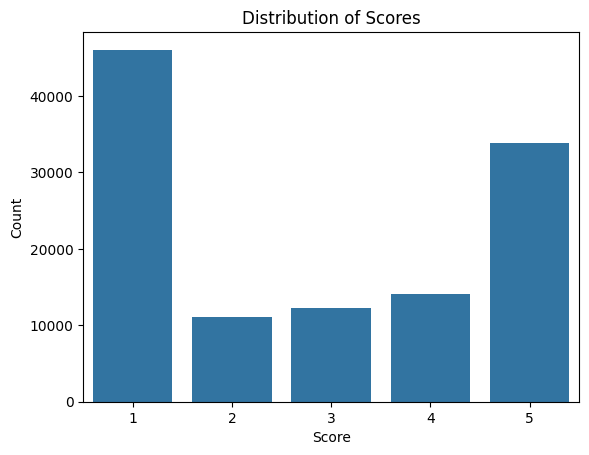

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt

# 1
score,scoreSum = [],[]

for i in range(1,6) :
    score.append(i)
    scoreSum.append(df['score'].value_counts().get(i,0))

sns.barplot(x=score, y=scoreSum)
plt.xlabel('Score')
plt.ylabel('Count')
plt.title('Distribution of Scores')
plt.show()

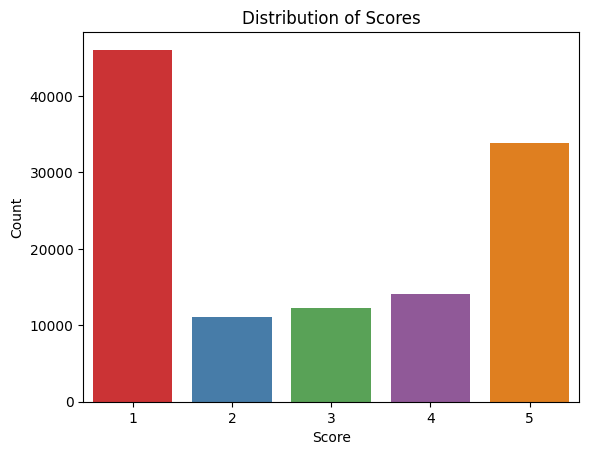

In [47]:
# 2

sns.barplot(x=df['score'].value_counts().index, 
            y=df['score'].value_counts().values,
            hue=df['score'].value_counts().index,
            palette='Set1', legend=False)
plt.xlabel('Score')
plt.ylabel('Count')
plt.title('Distribution of Scores')
plt.show()

In [49]:
# 필요한 열 선택 및 결측값 처리
df_ML = df[['content', 'score']].dropna()

# 데이터셋 클래스 정의
class ReviewDataset(Dataset):
    def __init__(self, reviews, ratings, text_pipeline, label_pipeline):
        self.reviews = reviews
        self.ratings = ratings
        self.text_pipeline = text_pipeline
        self.label_pipeline = label_pipeline

    def __len__(self):
        return len(self.reviews)

    def __getitem__(self, idx):
        review = self.text_pipeline(self.reviews[idx])
        rating = self.label_pipeline(self.ratings[idx])
        return torch.tensor(review), torch.tensor(rating)

# 텍스트 파이프라인 정의
tokenizer = get_tokenizer('basic_english')
def text_pipeline(text):
    return [vocab[token] for token in tokenizer(text)]

# 레이블 파이프라인 정의
label_encoder = LabelEncoder()
label_encoder.fit(['negative', 'neutral', 'positive'])  # 예시 레이블
def label_pipeline(label):
    return label_encoder.transform([label])[0]

# vocab 정의
# 어휘 생성 함수
def yield_tokens(data_iter):
    for text in data_iter:
        yield tokenizer(text)

# 특성과 타겟 분리
X = df_ML['content']
y = df_ML['score']

# 데이터 분할
train_reviews, test_reviews, train_ratings, test_ratings = train_test_split(X, y, test_size=0.2, random_state=42)

# 어휘 생성
vocab = build_vocab_from_iterator(yield_tokens(train_reviews), specials=["<unk>"])
vocab.set_default_index(vocab["<unk>"])  # 기본 인덱스를 <unk>로 설정

# 데이터셋 정의
train_dataset = ReviewDataset(train_reviews, train_ratings, text_pipeline, label_pipeline)
test_dataset = ReviewDataset(test_reviews, test_ratings, text_pipeline, label_pipeline)

# 데이터 로더 정의
BATCH_SIZE = 64

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# LSTM 모델 정의
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim):
        super(LSTMModel, self).__init__()
        self.embedding = nn.EmbeddingBag(vocab_size, embed_dim, sparse=True)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, text):
        embedded = self.embedding(text)
        output, (hidden, cell) = self.lstm(embedded.unsqueeze(0))
        return self.fc(hidden[-1])

# 하이퍼파라미터 정의
VOCAB_SIZE = len(vocab)
EMBED_DIM = 64
HIDDEN_DIM = 128
OUTPUT_DIM = len(df_ML['score'].unique())  # 예측할 점수 개수

# 모델 초기화
model = LSTMModel(VOCAB_SIZE, EMBED_DIM, HIDDEN_DIM, OUTPUT_DIM)

# 손실 함수와 옵티마이저 정의
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

# 모델 학습은 직접 작성해보세요!!!
# 모델 학습 함수
def train_model(model, train_dataloader, criterion, optimizer, num_epochs):
    model.train()  # 모델을 학습 모드로 설정
    for epoch in range(num_epochs):
        total_loss = 0
        for batch_idx, (reviews, ratings) in enumerate(train_dataloader):
            optimizer.zero_grad()  # 기울기 초기화
            output = model(reviews)  # 모델 예측
            loss = criterion(output, ratings)  # 손실 계산
            loss.backward()  # 역전파
            optimizer.step()  # 파라미터 업데이트

            total_loss += loss.item()  # 손실 누적

        avg_loss = total_loss / len(train_dataloader)  # 평균 손실 계산
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_loss:.4f}')

# 하이퍼파라미터 정의
NUM_EPOCHS = 10  # 학습할 에폭 수

# 모델 학습 시작
train_model(model, train_dataloader, criterion, optimizer, NUM_EPOCHS)

# 예측 함수(예시)
def predict_review(model, review):
    model.eval()
    with torch.no_grad():
        tensor_review = torch.tensor(text_pipeline(review))
        output = model(tensor_review)
        prediction = output.argmax(1).item()
        return label_encoder.inverse_transform([prediction])[0]

# 새로운 리뷰에 대한 예측
new_review = "This app is great but has some bugs."
predicted_score = predict_review(model, new_review)
print(f'Predicted Score: {predicted_score}')

ValueError: y contains previously unseen labels: '4'